In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error
from math import sqrt

import warnings #경고 미출력

import lightgbm as lgbm
from lightgbm import plot_importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno 

import pandas_profiling
from  tqdm import tqdm_notebook
from google.colab import drive

warnings.filterwarnings('ignore')
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# 학습 데이터와 검증 데이터 불러오기
train = "/content/drive/MyDrive/tempuv.pkl"
test =  "/content/drive/MyDrive/uv_test.csv"

train = pd.read_pickle(train)
test = pd.read_csv(test)

In [ ]:
test.drop("Unnamed: 0", axis=1, inplace=True)
test.columns = train.columns
test = test.astype({"landtype": "float64"})

#### 학습데이터 전처리

In [ ]:
#학습 데이터에서 UV는 결측치인거 제거하기
train = train.loc[train["UV"]!=-999, train.columns]

In [ ]:
# 학습 데이터 band 결측치 행 제거
bands = ['band1', 'band2',
       'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10',
       'band11', 'band12', 'band13', 'band14', 'band15', 'band16']
for band in bands:
    train = train.loc[train[band]!=-999, train.columns]

#학습 데이터 UV 이상치 제거
train = train.loc[train.UV<15, train.columns]

#### 검증데이터 전처리

In [ ]:
#interpolate 사용하기위해 -999값을 nan값으로 변환
for band in bands:
    test.loc[test[band]==-999, band] = np.nan

In [ ]:
#Band값 보간
test.sort_values(by=["STN", "yyyymmdd"], inplace=True)
test = test.interpolate(method='values', limit=1)

In [ ]:
test.sort_index(inplace=True)

### 컬럼 생성

In [ ]:
def Year(x):
    x = str(x)
    return int(x[:4])

def Month(x):
    x = str(x)
    return int(x[4:6])

def Day(x):
    x = str(x)
    return int(x[6:8])

def Hour(x):
    x = str(x)
    if len(x)==2:
        result = 0
    elif len(x)==3:
        result = int(x[0])
    else:
        result = int(x[:2])
    return result

def Min(x):
    x = str(x)
    if len(x)==1:
        result = 0
    elif len(x)>=2:
        result = int(x[-2:])
    return result

In [ ]:
#yyyymmdd, hhnn 변환 
train["year"] = train['yyyymmdd'].map(Year)
train["month"] = train['yyyymmdd'].map(Month)
train["day"] = train['yyyymmdd'].map(Day)
train["hour"] = train['hhnn'].map(Hour)
train["min"] = train['hhnn'].map(Min)

test["year"] = test['yyyymmdd'].map(Year)
test["month"] = test['yyyymmdd'].map(Month)
test["day"] = test['yyyymmdd'].map(Day)
test["hour"] = test['hhnn'].map(Hour)
test["min"] = test['hhnn'].map(Min)

In [ ]:
#hour sin, cos 변환
train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

test['sin_time'] = np.sin(2*np.pi*test.hour/24)
test['cos_time'] = np.cos(2*np.pi*test.hour/24)

In [ ]:
#month, landtype 원핫인코딩
train = pd.get_dummies(train, columns = ['month'])
for i in range(12):
    if i+1 == 6:
        test = pd.get_dummies(test, columns = ['month'])
    else:
        test[f"month_{i+1}"] = np.zeros(test.shape[0])

train = pd.get_dummies(train, columns = ['landtype'])
test = pd.get_dummies(test, columns = ['landtype'])

In [ ]:
#야간과 주간 나누기
train_day = train.loc[train.solarza<90, train.columns]
train_night = train.loc[train.solarza>=90, train.columns]

test_day = test.loc[test.solarza<90, test.columns]
test_night = test.loc[test.solarza>=90, test.columns]

In [ ]:
print(train.shape[0]==train_day.shape[0]+train_night.shape[0])
print(test.shape[0]==test_day.shape[0]+test_night.shape[0])

True
True


In [ ]:
train_day.reset_index(drop=True, inplace=True)

# 야간 모델 예측

In [ ]:
test_night["UV"] = 0

# 주간 모델 예측

In [ ]:
target_col = 'UV'
drop_cols = [target_col,'yyyymmdd', 'hhnn', 'year', "day", 'hour', 'min', "STN"]
train_label = train_day[target_col]
test_day[target_col] = np.NaN

In [ ]:
from sklearn.feature_selection import RFECV

target_col = 'UV'
drop_cols = [target_col,'yyyymmdd', 'hhnn', 'year', "day", 'hour', 'min', "STN"]
# LGBM params
n_splits= 5
NUM_BOOST_ROUND = 1000
SEED = 1993
random_state = 1
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':random_state,
              'learning_rate':0.1, #0.1
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.68,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 6600,
              "min_child_samples ":26,
              "max_depth": 14,
              'seed' : SEED
            }

reg_model = lgbm.LGBMRegressor(**lgbm_param)
rfe = RFECV(estimator=reg_model, step=1, cv=KFold(n_splits=5, shuffle=True, random_state=1),
            scoring="neg_mean_squared_error", verbose=2) #shuffle=False
rfe.fit(train_day.drop(drop_cols, 1), train_day["UV"])

df_rank = pd.DataFrame(data = {"col": list(train_day.drop(drop_cols, 1)), "imp": rfe.ranking_})
use_cols = list(df_rank[df_rank["imp"]==1]["col"])

Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 fe

In [ ]:
drops = ['yyyymmdd',
 'hhnn',
 'year',
 'hour',
 'day',
 'month_11',
 'STN',
 'month_1',
 'month_2',
 'landtype_2.0',
 'UV',
 'month_12',
 'landtype_4.0',
 'min']

In [ ]:
target_col = 'UV'
drop_cols = drops #[target_col,'yyyymmdd', 'hhnn', 'year', "day", 'hour', 'min', "STN"]
train_label = train_day[target_col]
test_day[target_col] = np.NaN

In [ ]:
# LGBM params
n_splits= 5
NUM_BOOST_ROUND = 2000 #1000
SEED = 1993
random_state = 1
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':random_state,
              'learning_rate':0.07, #0.1
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.68,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 6600,
              "min_child_samples ":26,
              "max_depth": 14,
              'seed' : SEED
            }

In [ ]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train_day.shape[0]))
lgbm_oof_test = np.zeros((test_day.shape[0]))

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)


# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train_day, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train_day.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train_day.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                    #    categorical_feature= ['month','landtype']
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
    lgbm_test_pred = model.predict(test_day.drop(drop_cols, 1))
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    lgbm_oof_test += lgbm_test_pred/ n_splits
    print('='*80)
    
print(f"<Light-GBM> OVERALL RMSE     : {sqrt( mean_squared_error( train_label, lgbm_oof_train ) )}")

0it [00:00, ?it/s]

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds.
[100]	train's rmse: 0.430155	valid's rmse: 0.514943
[200]	train's rmse: 0.364046	valid's rmse: 0.494719
[300]	train's rmse: 0.321939	valid's rmse: 0.485568
[400]	train's rmse: 0.291387	valid's rmse: 0.480745
[500]	train's rmse: 0.26722	valid's rmse: 0.477357
[600]	train's rmse: 0.24817	valid's rmse: 0.475082
[700]	train's rmse: 0.232922	valid's rmse: 0.473336
[800]	train's rmse: 0.219492	valid's rmse: 0.471934
[900]	train's rmse: 0.208378	valid's rmse: 0.470858
[1000]	train's rmse: 0.198608	valid's rmse: 0.46998
[1100]	train's rmse: 0.190238	valid's rmse: 0.469317
[1200]	train's rmse: 0.182711	valid's rmse: 0.468673
[1300]	train's rmse: 0.176007	valid's rmse: 0.468058
[1400]	train's rmse: 0.170084	valid's rmse: 0.467631
[1500]	train's rmse: 0.164642	valid's rmse: 0.467259
[1600]	train's rmse: 0.159592	valid's rmse: 0.466922
[1700]	train's rmse: 0.155116	valid's rmse: 0.466597
[1800]	train's rmse: 0.1

In [ ]:
test_day.columns

Index(['yyyymmdd', 'hhnn', 'STN', 'Lon', 'Lat', 'UV', 'band1', 'band2',
       'band3', 'band4', 'band5', 'band6', 'band7', 'band8', 'band9', 'band10',
       'band11', 'band12', 'band13', 'band14', 'band15', 'band16', 'solarza',
       'sateza', 'esr', 'height', 'year', 'day', 'hour', 'min', 'sin_time',
       'cos_time', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'landtype_0', 'landtype_2', 'landtype_3', 'landtype_4'],
      dtype='object')

In [ ]:
test_day.drop(drop_cols, 1).columns

KeyError: ignored

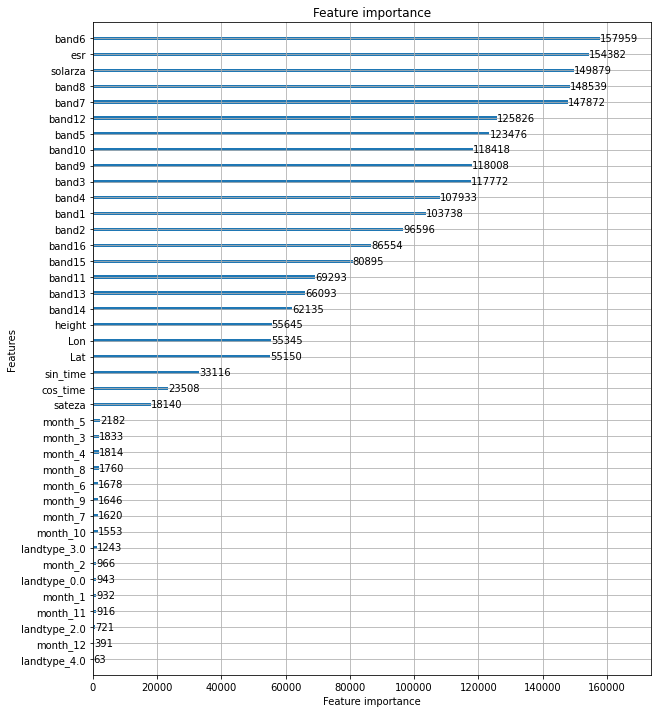

In [ ]:
fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(model, ax=ax)

In [ ]:
test_day["UV"] = np.clip(lgbm_oof_test, 0 , max(lgbm_oof_test))

In [ ]:
# test_night.loc[test_night.STN==146, "UV"] = 0.1

In [ ]:
 submission = pd.concat([test_night, test_day])
 submission.sort_values(by=["yyyymmdd","hhnn","STN"], inplace=True)

In [ ]:
def stringchange(x):
    x = str(int(x))
    return x

def stringchange1(x):
    x = str(int(x))
    if len(x) == 1:
        x = "000"+ x
    elif len(x) == 2:
        x = "00" + x
    elif len(x) == 3:
        x = "0" + x
    return x

submission['hhnn'] = submission['hhnn'].apply(stringchange1)
submission['yyyymmdd'] = submission['yyyymmdd'].apply(stringchange)
submission['YearMonthDayHourMinute'] = submission['yyyymmdd']+submission['hhnn']

In [ ]:
use_cols = ['YearMonthDayHourMinute', "STN", "UV"]
submission = submission[use_cols]

In [ ]:
submission = submission.astype({"YearMonthDayHourMinute": "int64"})

In [ ]:
submission.to_csv("/content/drive/MyDrive/submission/submission6.csv", index = None)